# CME538 - Introduction to Data Science
**Project 2 - Toronto Bike Share**

**Team: Diligent Debuggers**

**Team members:** 

# Setup Notebook

In [159]:
# Import 3rd party libraries
import os
import json
import time
import numpy as np
import datetime as dt
import codecs
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from io import StringIO
import pytz
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import geopandas as gpd


# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

# Data Cleaning

## Get Station Data
Get the up to date bikeshare station information from `https://tor.publicbikesystem.net`.

In [2]:
response = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')
bikeshare_stations = pd.DataFrame(json.loads(response.content)['data']['stations'])[['station_id', 'name', 'lat', 'lon', 'capacity']].astype({'station_id': 'int',})
bikeshare_stations = bikeshare_stations.rename(columns={'station_id': 'Station Id', 
                                                        'name': 'Station Name'})

# View DataFrame
bikeshare_stations.head(15)

,Station Id,Station Name,lat,lon,capacity
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954,35
1,7001,Wellesley Station Green P,43.664964,-79.383550,26
2,7002,St. George St / Bloor St W,43.667333,-79.399429,19
3,7003,Madison Ave / Bloor St W,43.667158,-79.402761,15
4,7004,University Ave / Elm St,43.656518,-79.389099,11
5,7005,King St W / York St,43.648001,-79.383177,19
6,7006,Bay St / College St (East Side),43.660439,-79.385525,19
7,7007,College St / Huron St,43.658148,-79.398167,19
8,7008,Wellesley St / Queen's Park Cres,43.663376,-79.392125,19
9,7009,King St E / Jarvis St,43.650325,-79.372287,25


In [3]:
bikeshare_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Station Id    655 non-null    int32  
 1   Station Name  655 non-null    object 
 2   lat           655 non-null    float64
 3   lon           655 non-null    float64
 4   capacity      655 non-null    int64  
dtypes: float64(2), int32(1), int64(1), object(1)
memory usage: 23.2+ KB


In [256]:
bikeshare_stations.nunique()

Station Id      655
Station Name    655
lat             653
lon             654
capacity         39
dtype: int64

The station dataframe has no missing/duplicated station name or id. 

In [7]:
# Write bikeshare station dataframe to a csv file
path_stations = os.path.join(os.path.abspath(os.getcwd()), 'data', 'stations')
bikeshare_stations.to_csv(os.path.join(path_stations, 'bikeshare_stations.csv'))

## Weather Data

### Load Weather Data

In [14]:
# Set weather data path
path_weather = os.path.join(os.path.abspath(os.getcwd()), 'data', 'weather')

# Get weather file names
weather_filenames = [filename for filename in os.listdir(path_weather) if 'climate' in filename]

# Print file names
print(weather_filenames[0:5])

['en_climate_hourly_ON_6158359_01-2017_P1H.csv', 'en_climate_hourly_ON_6158359_01-2018_P1H.csv', 'en_climate_hourly_ON_6158359_01-2019_P1H.csv', 'en_climate_hourly_ON_6158359_01-2020_P1H.csv', 'en_climate_hourly_ON_6158359_01-2021_P1H.csv']


In [17]:
# Create a dictionary where key:value pairs correspond to the file name and DataFrame respectively
weather_data = {filename: pd.read_csv(os.path.join(path_weather, filename)) for filename in weather_filenames}  

In [18]:
weather_rename = {
    'Date/Time (LST)' : 'Date/Time',
    'Time (LST)' : 'Time',
}

for filename in weather_filenames:
    weather_data[filename].rename(columns=weather_rename, inplace=True)

In [19]:
# Import weather
weather = pd.concat([weather_data[filename] for filename in weather_filenames], ignore_index=True)

# View DataFrame
weather.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Time,Temp (°C),...,Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather,Precip. Amount (mm),Precip. Amount Flag
0,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 00:00,2017,1,1,00:00,1.5,...,NaN,99.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 01:00,2017,1,1,01:00,1.5,...,NaN,100.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 02:00,2017,1,1,02:00,1.0,...,NaN,100.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 03:00,2017,1,1,03:00,1.2,...,NaN,100.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 04:00,2017,1,1,04:00,1.3,...,NaN,100.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49656 entries, 0 to 49655
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Longitude (x)        49656 non-null  float64
 1   Latitude (y)         49656 non-null  float64
 2   Station Name         49656 non-null  object 
 3   Climate ID           49656 non-null  int64  
 4   Date/Time            49656 non-null  object 
 5   Year                 49656 non-null  int64  
 6   Month                49656 non-null  int64  
 7   Day                  49656 non-null  int64  
 8   Time                 49656 non-null  object 
 9   Temp (°C)            49273 non-null  float64
 10  Temp Flag            331 non-null    object 
 11  Dew Point Temp (°C)  49012 non-null  float64
 12  Dew Point Temp Flag  593 non-null    object 
 13  Rel Hum (%)          49026 non-null  float64
 14  Rel Hum Flag         579 non-null    object 
 15  Wind Dir (10s deg)   46833 non-null 

### Drop Redundant Columns

Apart from the unnecessary columns specified in proposal, 'Stn Press (kPa)' is not important because small atmospheric pressure changes have infinitesimal effects on everyday activities.

In [21]:
weather_clean = weather.drop(['Year', 'Month', 'Day', 'Time', 'Station Name', 'Climate ID', 'Longitude (x)', 'Latitude (y)', 'Stn Press (kPa)'], axis=1)

* The 'Date/Time' column need to be converted to datetime variable and localized to 'EST' timezone.
* The 'Weather' column is the visual observation of the weather environment and appears to be important. The missing values in this column means a clear weather. So missing values should be assigned with 'Clear'.
* There are a number of columns containing the word 'Flag', and only contains NaN or 'M' values. According to Environment and Climate Change Canada, the 'M' represents 'missing' which means the data is unretrievable or unavailable. The flag columns can be removed since they only contain overlapping information.

In [22]:
# Look for and drop the columns containing the word 'Flag'
flag_columns = [col for col in weather.columns if 'Flag' in col]
weather_clean = weather_clean.drop(flag_columns, axis = 1)

In [23]:
weather_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49656 entries, 0 to 49655
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date/Time            49656 non-null  object 
 1   Temp (°C)            49273 non-null  float64
 2   Dew Point Temp (°C)  49012 non-null  float64
 3   Rel Hum (%)          49026 non-null  float64
 4   Wind Dir (10s deg)   46833 non-null  float64
 5   Wind Spd (km/h)      49581 non-null  float64
 6   Visibility (km)      49570 non-null  float64
 7   Hmdx                 8134 non-null   float64
 8   Wind Chill           8862 non-null   float64
 9   Weather              7442 non-null   object 
 10  Precip. Amount (mm)  15318 non-null  float64
dtypes: float64(9), object(2)
memory usage: 4.2+ MB


In [24]:
weather_clean['Wind Chill'].unique()

array([ nan,  -6.,  -2.,  -9., -11., -13., -14., -15., -17., -16., -18.,
       -19., -20., -21., -12., -10.,  -8.,  -7.,  -5.,  -4.,  -3., -22.,
       -26., -24., -23., -25., -28., -29., -31., -30., -27., -32., -33.,
       -35., -34., -36.,  -1.])

In [25]:
weather['Rel Hum (%)'].unique()

array([ 69.,  67.,  68.,  66.,  70.,  63.,  59.,  56.,  54.,  57.,  61.,
        71.,  76.,  74.,  77.,  85.,  83.,  79.,  78.,  84.,  90.,  82.,
        87.,  88.,  72.,  73.,  81.,  92.,  95.,  94.,  96.,  97.,  98.,
        93.,  80.,  65.,  53.,  60.,  64.,  58.,  62.,  49.,  47.,  48.,
        52.,  55.,  75.,  46.,  42.,  89.,  91.,  86.,  99.,  50.,  51.,
       100.,  45.,  43.,  41.,  38.,  36.,  40.,  44.,  32.,  34.,  25.,
        29.,  31.,  33.,  37.,  35.,  26.,  39.,  30.,  nan,  18.,  19.,
        27.,  28.,  20.,  24.,  23.,  17.,  21.,  16.,  22.])

In [26]:
weather['Wind Dir (10s deg)'].unique()

array([26., 27., 23., 24., 25., 22., nan,  3.,  5.,  6.,  8.,  7., 10.,
        9.,  4., 33., 28., 29., 31., 30., 32., 20., 21., 19., 18., 15.,
       14., 12., 13., 16., 17., 34., 35., 11.,  1., 36.,  2.])

### Datetime data

In [27]:
# Convert 'Date/Time' column to datetime variables
est = pytz.timezone('US/Eastern')
utc = pytz.utc

weather_clean['Date/Time'] = weather_clean['Date/Time'].apply(lambda _: est.localize(dt.datetime.strptime(_,'%Y-%m-%d %H:%M')))

In [28]:
weather_clean = weather_clean.set_index('Date/Time')
weather_clean.head()

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather,Precip. Amount (mm)
Date/Time,,,,,,,,,,
2017-01-01 00:00:00-05:00,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,NaN,NaN
2017-01-01 01:00:00-05:00,1.5,-3.9,67.0,27.0,35.0,16.1,NaN,NaN,NaN,NaN
2017-01-01 02:00:00-05:00,1.0,-4.3,68.0,26.0,32.0,16.1,NaN,NaN,NaN,NaN
2017-01-01 03:00:00-05:00,1.2,-4.3,67.0,26.0,37.0,16.1,NaN,NaN,NaN,NaN
2017-01-01 04:00:00-05:00,1.3,-4.4,66.0,26.0,28.0,16.1,NaN,NaN,NaN,NaN


### Missing Values

In [29]:
# Check missing values
display(weather_clean.isnull().sum(axis=0).to_frame('count'))

,count
Temp (°C),383
Dew Point Temp (°C),644
Rel Hum (%),630
Wind Dir (10s deg),2823
Wind Spd (km/h),75
Visibility (km),86
Hmdx,41522
Wind Chill,40794
Weather,42214
Precip. Amount (mm),34338


'Hmdx', 'Wind Chill', and 'Weather' columns have significantly more missing values than the other columns.

In [30]:
# Check missing values for each year
display(weather_clean.resample('Y').agg(lambda row: row.isnull().sum()))

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather,Precip. Amount (mm)
Date/Time,,,,,,,,,,
2017-12-31 00:00:00-05:00,11,11,10,530,9,11,7599,7251,7390,8760
2018-12-31 00:00:00-05:00,4,4,2,504,2,4,6979,7084,7336,8760
2019-12-31 00:00:00-05:00,95,145,145,595,23,24,7608,6936,7213,8760
2020-12-31 00:00:00-05:00,13,12,7,426,14,16,7211,7599,7494,8040
2021-12-31 00:00:00-05:00,26,52,47,476,21,16,7307,7383,7624,14
2022-12-31 00:00:00-05:00,234,420,419,292,6,15,4818,4541,5157,4


#### **Imputing/filling Hmdx and Wind Chill missing values**

According to Environment and Climate Change Canada (https://climate.weather.gc.ca/glossary_e.html), the humidex values are only reported if:

  (1) air temperature is greater than or equal to 20 degrees celsius and,
  
  (2) the humidex value is at least 1 degree greater than the air temperature. 
  
Similarily, wind chill is only calculated if the air temperature is greater than or equal to 0 degrees celsius.

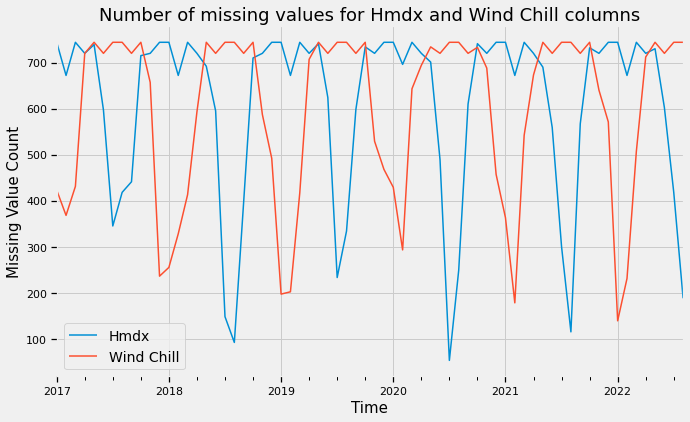

In [31]:
# Visualizing number of missing values in 'Hmdx' and 'Wind Chill' columns
weather_clean.resample('M').agg(lambda row: row.isnull().sum())[['Hmdx', 'Wind Chill']].plot(figsize = (10, 6))

plt.title('Number of missing values for Hmdx and Wind Chill columns', fontsize = 18)
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Missing Value Count', fontsize = 15)
plt.legend(['Hmdx', 'Wind Chill'], fontsize = 14)

We can find that there are more missing wind chill values and fewer missing humidex values in the summer, and vice versa in the winter. This agrees with the explanation provided by Environment and Climate Change Canada.

Therefore, the missing values in 'Hmdx' and 'Wind Chill' should not be modified.

#### **Imputing/filling Weather missing values**

In [32]:
# Modifying missing values in 'Weather' column
weather_clean['Weather'].fillna('Clear', inplace = True)
weather_clean.head()

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather,Precip. Amount (mm)
Date/Time,,,,,,,,,,
2017-01-01 00:00:00-05:00,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,Clear,NaN
2017-01-01 01:00:00-05:00,1.5,-3.9,67.0,27.0,35.0,16.1,NaN,NaN,Clear,NaN
2017-01-01 02:00:00-05:00,1.0,-4.3,68.0,26.0,32.0,16.1,NaN,NaN,Clear,NaN
2017-01-01 03:00:00-05:00,1.2,-4.3,67.0,26.0,37.0,16.1,NaN,NaN,Clear,NaN
2017-01-01 04:00:00-05:00,1.3,-4.4,66.0,26.0,28.0,16.1,NaN,NaN,Clear,NaN


#### **Imputing/filling missing values for other columns**

The weather data is sampled every hour, so it should be reasonable to impute missing values based on the time-adjacent valid observations. Except for 'Hmdx', 'Wind Chill', and 'Weather' columns, all other columns will have missing values filled using linear interpolation between valid observations.

In [33]:
# Linear interpolating values 
interpolating_col = weather_clean.columns.drop(['Hmdx', 'Wind Chill', 'Weather'])
weather_clean[interpolating_col] = weather_clean[interpolating_col].interpolate(
    method = 'linear', axis = 0, limit_direction = 'both').round(1)

In [34]:
# Check if there are still missing values
weather_clean.isnull().sum(axis=0).to_frame('count')

,count
Temp (°C),0
Dew Point Temp (°C),0
Rel Hum (%),0
Wind Dir (10s deg),0
Wind Spd (km/h),0
Visibility (km),0
Hmdx,41522
Wind Chill,40794
Weather,0
Precip. Amount (mm),0


### Outliers

Check if there are outliers for temperature.

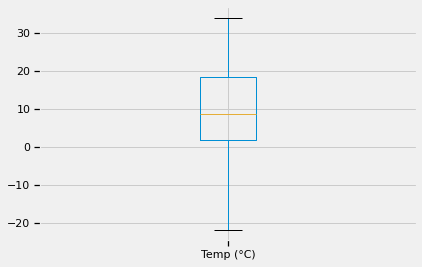

In [35]:
# draw boxplots to visualize outliers
plt.figure()
weather_clean.boxplot(column='Temp (°C)')
plt.show()

There is no need to remove outliers. The weather data is cleaned!

In [36]:
weather_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49656 entries, 2017-01-01 00:00:00-05:00 to 2021-12-31 23:00:00-05:00
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Temp (°C)            49656 non-null  float64
 1   Dew Point Temp (°C)  49656 non-null  float64
 2   Rel Hum (%)          49656 non-null  float64
 3   Wind Dir (10s deg)   49656 non-null  float64
 4   Wind Spd (km/h)      49656 non-null  float64
 5   Visibility (km)      49656 non-null  float64
 6   Hmdx                 8134 non-null   float64
 7   Wind Chill           8862 non-null   float64
 8   Weather              49656 non-null  object 
 9   Precip. Amount (mm)  49656 non-null  float64
dtypes: float64(9), object(1)
memory usage: 4.2+ MB


## Bike Share Trip Data

### Load Bike Share Trip Data

In [43]:
# Define the rubbish character in front of the 'trip id' columns in some files
rubbish = ''.join([chr(c) for c in codecs.BOM_UTF8])

def read_bikeshare_csv(path):
    """
    Create a function t"o read bike share trips csv files without the rubbish character.
    """
    with open(path, encoding='utf-8') as f:
        txt = f.read()
        if txt.startswith(rubbish):
            txt = txt[len(rubbish):]
            
        return pd.read_csv(StringIO(txt), encoding='utf-8', encoding_errors='ignore')

In [44]:
# Set bikeshare data path
path_ridership = os.path.join(os.path.abspath(os.getcwd()), 'data', 'ridership')

# Create a list of file names for bike share trips data
trips_filenames = [filename for filename in os.listdir(path_ridership) if 'bike_share' in filename]

# Create a dictionary where key:value pairs correspond to the file name and DataFrame respectively
trips_data = {filename: read_bikeshare_csv(os.path.join(path_ridership, filename)) for filename in trips_filenames}  

In [45]:
# Check the column names of all files
for filename in trips_filenames:
    print(format(trips_data[filename].columns.tolist()))

['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds', 'from_station_id', 'from_station_name', 'to_station_id', 'to_station_name', 'user_type']
['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds', 'from_station_id', 'from_station_name', 'to_station_id', 'to_station_name', 'user_type']
['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds', 'from_station_id', 'from_station_name', 'to_station_id', 'to_station_name', 'user_type']
['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds', 'from_station_id', 'from_station_name', 'to_station_id', 'to_station_name', 'user_type']
['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds', 'from_station_id', 'from_station_name', 'to_station_id', 'to_station_name', 'user_type']
['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds', 'from_station_id', 'from_station_name', 'to_station_id', 'to_station_name', 'user_type']
['trip_id', 'trip_star

In [46]:
# Rename the columns in 2017 and 2018 data
trips_rename = {
    'trip_id' : 'Trip Id',
    'trip_start_time' : 'Start Time',
    'trip_stop_time' : 'End Time',
    'trip_duration_seconds' : 'Trip Duration',
    'from_station_id' : 'Start Station Id',
    'from_station_name' : 'Start Station Name',
    'to_station_id' : 'End Station Id',
    'to_station_name' : 'End Station Name',
    'user_type' : 'User Type'
}

for filename in trips_filenames:
    if ('2017' in filename) or ('2018' in filename):
        trips_data[filename].rename(columns=trips_rename, inplace=True)
    else:
        trips_data[filename].rename(columns={'Trip  Duration' : 'Trip Duration'}, inplace=True)

In [47]:
# Concatenate the ridership data into one dataframe 
ridership = pd.concat([trips_data[filename] for filename in trips_filenames], ignore_index=True)

# View DataFrame
ridership.head()

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type,Subscription Id,Bike Id
0,712441,2017-01-01 05:03 (UTC),2017-01-01 05:08 (UTC),274,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Member,NaN,NaN
1,712442,2017-01-01 05:03 (UTC),2017-01-01 05:12 (UTC),538,7046.0,Niagara St / Richmond St W,7147.0,King St W / Fraser Ave,Member,NaN,NaN
2,712443,2017-01-01 05:05 (UTC),2017-01-01 05:22 (UTC),992,7048.0,Front St / Yonge St (Hockey Hall of Fame),7089.0,Church St / Wood St,Member,NaN,NaN
3,712444,2017-01-01 05:09 (UTC),2017-01-01 05:26 (UTC),1005,7177.0,East Liberty St / Pirandello St,7202.0,Queen St W / York St (City Hall),Member,NaN,NaN
4,712445,2017-01-01 05:14 (UTC),2017-01-01 05:25 (UTC),645,7203.0,Bathurst St / Queens Quay W,7010.0,King St W / Spadina Ave,Member,NaN,NaN


In [48]:
ridership.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15358993 entries, 0 to 15358992
Data columns (total 11 columns):
 #   Column              Non-Null Count     Dtype  
---  ------              --------------     -----  
 0   Trip Id             15358993 non-null  int64  
 1   Start Time          15358993 non-null  object 
 2   End Time            15358992 non-null  object 
 3   Trip Duration       15358993 non-null  int64  
 4   Start Station Id    14332100 non-null  float64
 5   Start Station Name  15262057 non-null  object 
 6   End Station Id      14327681 non-null  float64
 7   End Station Name    15256259 non-null  object 
 8   User Type           15358993 non-null  object 
 9   Subscription Id     5052221 non-null   float64
 10  Bike Id             11943393 non-null  float64
dtypes: float64(4), int64(2), object(5)
memory usage: 1.3+ GB


In [49]:
ridership['User Type'].unique()

array(['Member', 'Casual', 'Annual Member', 'Casual Member'], dtype=object)

Problems in the dataset:
* There are a lot of null values.
* Start Time and End Time values need to be first converted into datatime variables with timezone info and then converted to 'US/Eastern' timezone.
* User Types need to be unified.

### Drop Redundant Columns

In [50]:
#Drop Bike ID and Subscription ID columns
ridership.drop(['Subscription Id', 'Bike Id'], axis=1, inplace=True)

In [51]:
user_rename = {
    'Annual Member' : 'Member',
    'Casual Member' : 'Casual'
}

ridership.rename(columns=user_rename, inplace=True)

In [52]:
ridership.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15358993 entries, 0 to 15358992
Data columns (total 9 columns):
 #   Column              Non-Null Count     Dtype  
---  ------              --------------     -----  
 0   Trip Id             15358993 non-null  int64  
 1   Start Time          15358993 non-null  object 
 2   End Time            15358992 non-null  object 
 3   Trip Duration       15358993 non-null  int64  
 4   Start Station Id    14332100 non-null  float64
 5   Start Station Name  15262057 non-null  object 
 6   End Station Id      14327681 non-null  float64
 7   End Station Name    15256259 non-null  object 
 8   User Type           15358993 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 1.0+ GB


In [53]:
#Set Trip ID to index
ridership.set_index('Trip Id')

,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
Trip Id,,,,,,,,
712441,2017-01-01 05:03 (UTC),2017-01-01 05:08 (UTC),274,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Member
712442,2017-01-01 05:03 (UTC),2017-01-01 05:12 (UTC),538,7046.0,Niagara St / Richmond St W,7147.0,King St W / Fraser Ave,Member
712443,2017-01-01 05:05 (UTC),2017-01-01 05:22 (UTC),992,7048.0,Front St / Yonge St (Hockey Hall of Fame),7089.0,Church St / Wood St,Member
712444,2017-01-01 05:09 (UTC),2017-01-01 05:26 (UTC),1005,7177.0,East Liberty St / Pirandello St,7202.0,Queen St W / York St (City Hall),Member
712445,2017-01-01 05:14 (UTC),2017-01-01 05:25 (UTC),645,7203.0,Bathurst St / Queens Quay W,7010.0,King St W / Spadina Ave,Member
...,...,...,...,...,...,...,...,...
18317445,31/08/2022 23:58:00 (EST),01/09/2022 00:26:00 (EST),1670,7100.0,Dundas St E / Regent Park Blvd,7322.0,King St W / Brant St,Casual Member
18317447,31/08/2022 23:58:00 (EST),01/09/2022 00:08:00 (EST),574,7245.0,Tecumseth St / Queen St W - SMART,7069.0,Queen St W / Spadina Ave,Annual Member
18317448,31/08/2022 23:59:00 (EST),01/09/2022 00:08:00 (EST),533,7257.0,Dundas St W / St. Patrick St,7037.0,Bathurst St / Dundas St W,Casual Member


In [54]:
ridership[ridership['End Time'].isnull()==True]

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
337055,2302635,2017-11-29 10:53 (UTC),NaN,0,NaN,Seaton St / Dundas St E,NaN,NaN,Casual


In [55]:
#Drop the row with null End Time
ridership = ridership[ridership['End Time'].isnull()==False]

In [56]:
# Check if there are duplicate trips
ridership['Trip Id'].nunique() / len(ridership)

0.9999991535902877

In [57]:
trip_duplicates = ridership[ridership.duplicated('Trip Id')]

In [58]:
trip_duplicates

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
9614632,10756846,03/02/2021 17:11:00 (EST),03/02/2021 17:11:00 (EST),0,7207.0,Dundas St W / Crawford St,7112.0,Liberty St / Fraser Ave Green P,Annual Member
9735699,10909571,18/03/2021 17:32:00 (EST),18/03/2021 17:32:00 (EST),0,7351.0,Pretoria Av / Broadview Av,7286.0,Gerrard St E / Broadview - SMART,Annual Member
9768054,10947892,22/03/2021 19:02:00 (EST),22/03/2021 19:02:00 (EST),0,7119.0,Sumach St / Carlton St. (Riverdale Farm),7458.0,Church St / Lombard St,Casual Member
9773782,10954749,23/03/2021 17:49:00 (EST),23/03/2021 17:49:00 (EST),0,7254.0,Borden St / Bloor St W - SMART,7023.0,College St / Borden St,Annual Member
9804453,10991914,28/03/2021 17:45:00 (EST),28/03/2021 17:45:00 (EST),0,7248.0,Baldwin Ave / Spadina Ave - SMART,7020.0,Phoebe St / Spadina Ave,Casual Member
9805407,10993058,28/03/2021 21:42:00 (EST),28/03/2021 21:42:00 (EST),0,7043.0,Queens Quay W / Lower Simcoe St,7020.0,Phoebe St / Spadina Ave,Casual Member
9814828,11004236,30/03/2021 16:45:00 (EST),30/03/2021 16:45:00 (EST),0,7656.0,Bloor St W / Brock Ave,7240.0,Bloor St W / Shaw Ave - SMART,Annual Member
9965013,11180718,18/04/2021 15:50:00 (EST),18/04/2021 15:50:00 (EST),0,7271.0,Yonge St / Alexander St - SMART,7267.0,Dundas St E / Pembroke St - SMART,Annual Member
10000997,11224466,24/04/2021 14:14:00 (EST),24/04/2021 14:14:00 (EST),0,7649.0,Greenwood Subway Station - SMART,7611.0,Victoria Park Ave / Danforth Ave,Annual Member
10008873,11233036,24/04/2021 18:09:00 (EST),24/04/2021 18:09:00 (EST),0,7017.0,Widmer St / Adelaide St W,7634.0,University Ave / Gerrard St W (WEST) - SMART,Casual Member


The duplicated trips have zero trip duration, and will removed later when removing trip duration outliers.

### Split ridership data for different years 

In [59]:
# Separate ridership data according to year
ridership_2017 = ridership.loc[ridership['Start Time'].str.contains('2017')]
ridership_2018 = ridership.loc[ridership['Start Time'].str.contains('2018')]
ridership_2019 = ridership.loc[ridership['Start Time'].str.contains('2019')]
ridership_2020 = ridership.loc[ridership['Start Time'].str.contains('2020')]
ridership_2021 = ridership.loc[ridership['Start Time'].str.contains('2021')]
ridership_2022 = ridership.loc[ridership['Start Time'].str.contains('2022')]

### Datetime data

In [60]:
def time_convert(df):
    """Convert Start Time and End Time into datetime variables
    Using to_datetime and a specified format
    Solved DST issue. ambiguous=True, nonexistent='shift_backward'
    """
    df_copy = df.copy()
    if 'UTC' in df_copy['Start Time'].iloc[0]:
        df_copy['Start Time'] = pd.to_datetime(df['Start Time'].str[:16]).dt.tz_localize('UTC', ambiguous=True, nonexistent='shift_backward').dt.tz_convert('US/Eastern')
        df_copy['End Time'] = pd.to_datetime(df['End Time'].str[:16]).dt.tz_localize('UTC', ambiguous=True, nonexistent='shift_backward').dt.tz_convert('US/Eastern')
    else:
        df_copy['Start Time'] = pd.to_datetime(df['Start Time'].str[:16]).dt.tz_localize('US/Eastern', ambiguous=True, nonexistent='shift_backward')
        df_copy['End Time'] = pd.to_datetime(df['End Time'].str[:16]).dt.tz_localize('US/Eastern', ambiguous=True, nonexistent='shift_backward')
   
    return df_copy

### Missing Values

ridership_est dataframe is separated into smaller dataframes according to year for better analyzing.

In [61]:
def remove_outliers(data):
    """
    Create a function to remove the duration outliers in the dataset
    """
    # Narrow down our dataset with 60 seconds duration filter
    data_copy = data.copy()
    data =data[data['Trip Duration']>=60]
    
    # Compute quartiles
    Q1 =data ['Trip Duration'].quantile(0.25)
    Q3 =data ['Trip Duration'].quantile(0.75)
    IQR = Q3 - Q1
    data  = data[(data['Trip Duration']<=(Q3+1.5*IQR)) & (data['Trip Duration']>=(Q1-1.5*IQR))]
    print("Percent of outliers removed: {}%".format((1-len(data) / len(data_copy)) * 100))
    return data

#### **2017 Data**

In [62]:
ridership_est_2017 = time_convert(ridership_2017)

In [63]:
# Remove trip duration outliers
ridership_est_2017 = remove_outliers(ridership_est_2017)

Percent of outliers removed: 7.65510161413967%


In [64]:
ridership_est_2017.isnull().sum()

Trip Id                    0
Start Time                 0
End Time                   0
Trip Duration              0
Start Station Id      934205
Start Station Name         0
End Station Id        934205
End Station Name           0
User Type                  0
dtype: int64

The missing Station Id can be imputed using the Station Data

In [65]:
#The trips with missing Station Id
ridership_est_2017[
    (ridership_est_2017['Start Station Id'].isnull()==True) | 
    (ridership_est_2017['End Station Id'].isnull()==True)].head()

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
41417,1971685,2017-10-01 01:00:00-04:00,2017-10-01 01:14:00-04:00,849,NaN,Queen St W / James St,NaN,Taddle Creek Park,Member
41419,1971687,2017-10-01 01:00:00-04:00,2017-10-01 01:22:00-04:00,1310,NaN,Hayter St / Laplante Ave,NaN,Queen St W / Portland St,Member
41420,1971688,2017-10-01 01:00:00-04:00,2017-10-01 01:11:00-04:00,631,NaN,Beverly St / College St,NaN,Beverly St / Dundas St W,Member
41421,1971689,2017-10-01 01:00:00-04:00,2017-10-01 01:20:00-04:00,1198,NaN,Thompson St / Broadview Ave - SMART,NaN,Thompson St / Broadview Ave - SMART,Member
41422,1971690,2017-10-01 01:01:00-04:00,2017-10-01 01:07:00-04:00,396,NaN,Dundonald St / Church St,NaN,Victoria St / Gould St (Ryerson University),Member


We will use station data as a reference to fill missing Start or End Station Id values.

In [66]:
# Create a fill_ID function for filling missing station ID according to station name
def fill_ID(df):
    """This function is for filling missing station names according to station ID
    Use the bikeshare_stations as reference.
    """
    df['Start Station Id'].fillna(
        df['Start Station Name'].map(bikeshare_stations.set_index('Station Name')['Station Id']),
        inplace=True)
    
    df['End Station Id'].fillna(
        df['End Station Name'].map(bikeshare_stations.set_index('Station Name')['Station Id']),
        inplace=True)
    
    return df

In [67]:
# Create a fill_name function for filling missing station name according to station ID
def fill_name(df):
    """This function is for filling missing station names according to station ID.
    Use the bikeshare_stations as reference.
    """
    df['Start Station Name'].fillna(
        df['Start Station Id'].map(bikeshare_stations.set_index('Station Id')['Station Name']),
        inplace=True)
    
    df['End Station Name'].fillna(
        df['End Station Id'].map(bikeshare_stations.set_index('Station Id')['Station Name']),
        inplace=True)
    
    return df

In [68]:
fill_ID(ridership_est_2017)

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
0,712441,2017-01-01 00:03:00-05:00,2017-01-01 00:08:00-05:00,274,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Member
1,712442,2017-01-01 00:03:00-05:00,2017-01-01 00:12:00-05:00,538,7046.0,Niagara St / Richmond St W,7147.0,King St W / Fraser Ave,Member
2,712443,2017-01-01 00:05:00-05:00,2017-01-01 00:22:00-05:00,992,7048.0,Front St / Yonge St (Hockey Hall of Fame),7089.0,Church St / Wood St,Member
3,712444,2017-01-01 00:09:00-05:00,2017-01-01 00:26:00-05:00,1005,7177.0,East Liberty St / Pirandello St,7202.0,Queen St W / York St (City Hall),Member
4,712445,2017-01-01 00:14:00-05:00,2017-01-01 00:25:00-05:00,645,7203.0,Bathurst St / Queens Quay W,7010.0,King St W / Spadina Ave,Member
...,...,...,...,...,...,...,...,...,...
1492364,1971680,2017-10-01 00:59:00-04:00,2017-10-01 01:04:00-04:00,337,7031.0,Jarvis St / Isabella St,7126.0,Yonge St / Yorkville Ave,Member
1492365,1971681,2017-10-01 00:59:00-04:00,2017-10-01 01:07:00-04:00,494,7024.0,Dundonald St / Church St,NaN,Victoria St / Gould St (Ryerson University),Member
1492366,1971682,2017-10-01 00:59:00-04:00,2017-10-01 01:18:00-04:00,1114,7248.0,Baldwin Ave / Spadina Ave - SMART,7135.0,Hanna Ave / Liberty St,Member
1492367,1971683,2017-10-01 00:59:00-04:00,2017-10-01 01:19:00-04:00,1192,7043.0,Queens Quay W / Lower Simcoe St,7243.0,Exhibition GO Station,Casual


In [69]:
fill_name(ridership_est_2017)

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
0,712441,2017-01-01 00:03:00-05:00,2017-01-01 00:08:00-05:00,274,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Member
1,712442,2017-01-01 00:03:00-05:00,2017-01-01 00:12:00-05:00,538,7046.0,Niagara St / Richmond St W,7147.0,King St W / Fraser Ave,Member
2,712443,2017-01-01 00:05:00-05:00,2017-01-01 00:22:00-05:00,992,7048.0,Front St / Yonge St (Hockey Hall of Fame),7089.0,Church St / Wood St,Member
3,712444,2017-01-01 00:09:00-05:00,2017-01-01 00:26:00-05:00,1005,7177.0,East Liberty St / Pirandello St,7202.0,Queen St W / York St (City Hall),Member
4,712445,2017-01-01 00:14:00-05:00,2017-01-01 00:25:00-05:00,645,7203.0,Bathurst St / Queens Quay W,7010.0,King St W / Spadina Ave,Member
...,...,...,...,...,...,...,...,...,...
1492364,1971680,2017-10-01 00:59:00-04:00,2017-10-01 01:04:00-04:00,337,7031.0,Jarvis St / Isabella St,7126.0,Yonge St / Yorkville Ave,Member
1492365,1971681,2017-10-01 00:59:00-04:00,2017-10-01 01:07:00-04:00,494,7024.0,Dundonald St / Church St,NaN,Victoria St / Gould St (Ryerson University),Member
1492366,1971682,2017-10-01 00:59:00-04:00,2017-10-01 01:18:00-04:00,1114,7248.0,Baldwin Ave / Spadina Ave - SMART,7135.0,Hanna Ave / Liberty St,Member
1492367,1971683,2017-10-01 00:59:00-04:00,2017-10-01 01:19:00-04:00,1192,7043.0,Queens Quay W / Lower Simcoe St,7243.0,Exhibition GO Station,Casual


In [70]:
ridership_est_2017.isnull().sum()

Trip Id                    0
Start Time                 0
End Time                   0
Trip Duration              0
Start Station Id      236883
Start Station Name         0
End Station Id        241751
End Station Name           0
User Type                  0
dtype: int64

Missing Station Id can be reduced using fill_ID. But there are still lots of missing values.

In [71]:
#Check again the trips with missing Station Id
ridership_est_2017[
    (ridership_est_2017['Start Station Id'].isnull()==True) | 
    (ridership_est_2017['End Station Id'].isnull()==True)].head()

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
41419,1971687,2017-10-01 01:00:00-04:00,2017-10-01 01:22:00-04:00,1310,7162.0,Hayter St / Laplante Ave,NaN,Queen St W / Portland St,Member
41420,1971688,2017-10-01 01:00:00-04:00,2017-10-01 01:11:00-04:00,631,NaN,Beverly St / College St,NaN,Beverly St / Dundas St W,Member
41422,1971690,2017-10-01 01:01:00-04:00,2017-10-01 01:07:00-04:00,396,7024.0,Dundonald St / Church St,NaN,Victoria St / Gould St (Ryerson University),Member
41423,1971691,2017-10-01 01:01:00-04:00,2017-10-01 01:11:00-04:00,592,NaN,Widmer St / Adelaide St W,7033.0,Union Station,Casual
41424,1971692,2017-10-01 01:01:00-04:00,2017-10-01 01:14:00-04:00,810,NaN,Stewart St / Bathurst St - SMART,7022.0,Simcoe St / Queen St W,Casual


The remaining missing values are because there are inconsistency issues with the station name column. Some of the stations names can't be found in bikeshare_stations data possibly due to station upgrade or typos. So we need to update the Station Names based on bikeshare_stations data.

In [72]:
# Obtain an updated station name list from station dataset
station_names = bikeshare_stations['Station Name'].unique()

The stations without Station ID may not have exact matched names in bikeshare_station data, but we can probably find entries with the same names in ridership data that has Station ID. Since one station ID may relate to multiple messy names, but one station can only have one station ID. We can then use this ID to find the updated name for each station.

In [73]:
# Extract both starting station names and ending station names from the ridership dataframe as old station names
stations_start = ridership[['Start Station Id', 'Start Station Name']]
stations_end = ridership[['End Station Id', 'End Station Name']]
stations_start.columns = stations_end.columns = ['Station Id', 'Station Name']

In [74]:
# Combine the stations into a single dataframe stations_old
stations_old = pd.concat([stations_start, stations_end]).dropna(how='all').drop_duplicates().reset_index(drop=True)
stations_old = stations_old.dropna(subset='Station Name')

# Drop rows with duplicate station names, keeping the one with a Station Id
stations_old = stations_old.sort_values(['Station Id'], na_position='last').drop_duplicates('Station Name', keep='first')

In [75]:
stations_old.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817 entries, 477 to 470
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Station Id    807 non-null    float64
 1   Station Name  817 non-null    object 
dtypes: float64(1), object(1)
memory usage: 19.1+ KB


In [76]:
stations_old.nunique()

Station Id      626
Station Name    817
dtype: int64

In [77]:
# try finding the stations with missing ID using bikeshare_stations data
stations_old['Station Id'].fillna(
    stations_old['Station Name'].map(bikeshare_stations.set_index('Station Name')['Station Id']),
    inplace=True)

In [78]:
# Separate the stations names that has no station ID
stations_old_ID = stations_old[stations_old['Station Id'].isnull()==False]
stations_old_noID = stations_old[stations_old['Station Id'].isnull()==True]
stations_old_noID

,Station Id,Station Name
203,NaN,Beverly St / College St
218,NaN,Dovercourt Rd / Harrison St - SMART
226,NaN,Roxton Rd / College St
249,NaN,Michael Sweet Ave / St. Patrick St
263,NaN,Lansdowne Subway Green P
303,NaN,Lake Shore Blvd W / Ontario Dr(Ontario Place)
306,NaN,Fringe Next Stage - 7219
411,NaN,Margueretta St / College St
445,NaN,Summerhill Ave / MacLennan Ave - SMART
470,NaN,Base Station


These stations may have new names in the updated bikeshare_stations data. So we can use fuzz to find their possible new name and then try to fill their missing ID.

In [79]:
# Create a find_fuzz function for find the updated station names using fuzz
# we use token sort ratio from fuzz to match two similar strings as possible pairs
# of old and new station names. If the order in which the words are placed in 
# a particular sentence doesn’t matter then the best way to match two strings 
# is by the use of Token Sort Ratio.

def find_fuzz(old_name, station_names):
    """This function creates a dictionary to update an old_name 
    with a new name (the station names in the bikeshare_station dataset).
    """
    # When the matching score is below threshold, the output is 'No Match Station'
    result_dict  = {0: 'No Match Station'}
    
    if old_name in station_names:
        return old_name
    else:
        for new_name in station_names:
            if fuzz.token_sort_ratio(new_name,old_name) >= 80:
                result_dict[fuzz.token_sort_ratio(new_name,old_name)] = str(new_name)
    
    result = result_dict[max(result_dict.keys())]
    
    return result

In [80]:
# Create a fuzz_replace function for replacing the name found by find_fuzz
def fuzz_replace(old_name):
    """This function is to replace the old station name in a dataframe. 
    """
    
    if old_name in find_fuzzname['Station Name']:
        return find_fuzzname[find_fuzzname['Station Name']==old_name]['possible_new_name'].tolist()[0]
    else:
        return old_name

In [81]:
# find possible new names for the stations with no ID
find_fuzzname = stations_old_noID.copy()
find_fuzzname['possible_new_name'] = find_fuzzname['Station Name'].apply(lambda row: find_fuzz(row, station_names))
find_fuzzname

,Station Id,Station Name,possible_new_name
203,NaN,Beverly St / College St,Beverley St / College St
218,NaN,Dovercourt Rd / Harrison St - SMART,Dovercourt Rd / Harrison St (Green P) - SMART
226,NaN,Roxton Rd / College St,No Match Station
249,NaN,Michael Sweet Ave / St. Patrick St,No Match Station
263,NaN,Lansdowne Subway Green P,No Match Station
303,NaN,Lake Shore Blvd W / Ontario Dr(Ontario Place),Lake Shore Blvd W / Ontario Dr
306,NaN,Fringe Next Stage - 7219,No Match Station
411,NaN,Margueretta St / College St,No Match Station
445,NaN,Summerhill Ave / MacLennan Ave - SMART,Summerhill Ave / Maclennan Ave
470,NaN,Base Station,No Match Station


We can then have a look at it and manually replace some statins with their actual name.

The stations with no match name can be drop since they are probably canceled stations with no known station ID and they are a small part of the whole stations.

In [82]:
# Manually select some stations with their actual name
fuzznames = ['Beverly St / College St', 
             'Dovercourt Rd / Harrison St - SMART',
             'Lake Shore Blvd W / Ontario Dr(Ontario Place)',
             'Summerhill Ave / MacLennan Ave - SMART']

find_fuzzname = find_fuzzname[find_fuzzname['Station Name'].isin(fuzznames)]

In [83]:
# fill the missing stations Id with possible new names in find_fuzzname
find_fuzzname['Station Id'].fillna(
    find_fuzzname['possible_new_name'].map(bikeshare_stations.set_index('Station Name')['Station Id']),
    inplace=True)

find_fuzzname

,Station Id,Station Name,possible_new_name
203,7161.0,Beverly St / College St,Beverley St / College St
218,7249.0,Dovercourt Rd / Harrison St - SMART,Dovercourt Rd / Harrison St (Green P) - SMART
303,7242.0,Lake Shore Blvd W / Ontario Dr(Ontario Place),Lake Shore Blvd W / Ontario Dr
445,7488.0,Summerhill Ave / MacLennan Ave - SMART,Summerhill Ave / Maclennan Ave


In [84]:
# Now combine the stations_old
stations_old_noID = find_fuzzname.drop(columns='possible_new_name')
stations_old = pd.concat([stations_old_ID, stations_old_noID])

In [85]:
stations_old.nunique()

Station Id      626
Station Name    811
dtype: int64

In [86]:
stations_old.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811 entries, 477 to 445
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Station Id    811 non-null    float64
 1   Station Name  811 non-null    object 
dtypes: float64(1), object(1)
memory usage: 19.0+ KB


The result means that each station name have only one ID, but it's name can be different due to typos or historical reasons. And we are able to find all stations that have station Id here with their messy names.

In [259]:
# Merge the stations_old with bikeshare_stations so that each messy station name 
# can relate to a new name and its Id
stations_merge = pd.merge(stations_old, 
                          bikeshare_stations, 
                          on='Station Id', 
                          how='left',
                          suffixes=('_messy', '_new')
                         ).drop_duplicates(subset='Station Name_messy')

We already made sure that each messy station name has its only one ID, but it's possible that these stations are removed now, so we may not have a new station name for them. We need to find these canceled stations.

In [260]:
# find stations that has no station name related according to station ID
station_is_canceled = stations_merge['Station Name_new'].isnull()
stations_merge[station_is_canceled]

,Station Id,Station Name_messy,Station Name_new,lat,lon,capacity
16,7011.0,Wellington St W / Portland St,NaN,NaN,NaN,NaN
18,7013.0,Scott St / The Esplanade,NaN,NaN,NaN,NaN
22,7017.0,Widmer St / Adelaide St,NaN,NaN,NaN,NaN
23,7017.0,Widmer St / Adelaide St W,NaN,NaN,NaN,NaN
25,7019.0,Temperance St / Yonge St,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
762,7638.0,Warehouse EBS-Station,NaN,NaN,NaN,NaN
777,7649.0,Greenwood Subway Station,NaN,NaN,NaN,NaN
778,7649.0,Greenwood Subway Station - SMART,NaN,NaN,NaN,NaN
780,7651.0,Bloor St W / Gladstone Ave,NaN,NaN,NaN,NaN


**We can't find a new station name for these stations using their ID, meaning that they are canceled now. So we add a suffix "_canceled" to its name to be the new station name.**

In [261]:
stations_merge['Station Name_new'].fillna(
        stations_merge['Station Name_messy']+'_canceled',
        inplace=True)

In [262]:
stations_merge[station_is_canceled]

,Station Id,Station Name_messy,Station Name_new,lat,lon,capacity
16,7011.0,Wellington St W / Portland St,Wellington St W / Portland St_canceled,NaN,NaN,NaN
18,7013.0,Scott St / The Esplanade,Scott St / The Esplanade_canceled,NaN,NaN,NaN
22,7017.0,Widmer St / Adelaide St,Widmer St / Adelaide St _canceled,NaN,NaN,NaN
23,7017.0,Widmer St / Adelaide St W,Widmer St / Adelaide St W_canceled,NaN,NaN,NaN
25,7019.0,Temperance St / Yonge St,Temperance St / Yonge St_canceled,NaN,NaN,NaN
...,...,...,...,...,...,...
762,7638.0,Warehouse EBS-Station,Warehouse EBS-Station_canceled,NaN,NaN,NaN
777,7649.0,Greenwood Subway Station,Greenwood Subway Station_canceled,NaN,NaN,NaN
778,7649.0,Greenwood Subway Station - SMART,Greenwood Subway Station - SMART_canceled,NaN,NaN,NaN
780,7651.0,Bloor St W / Gladstone Ave,Bloor St W / Gladstone Ave_canceled,NaN,NaN,NaN


All the canceled station names are renamed! Now let's have a look at the stations_merge dataframe.

In [263]:
stations_merge.head()

,Station Id,Station Name_messy,Station Name_new,lat,lon,capacity
0,7000.0,Fort York Blvd / Capreol Ct,Fort York Blvd / Capreol Ct,43.639832,-79.395954,35.0
1,7000.0,Fort York Blvd / Capreol Crt,Fort York Blvd / Capreol Ct,43.639832,-79.395954,35.0
2,7001.0,Lower Jarvis St / The Esplanade,Wellesley Station Green P,43.664964,-79.383550,26.0
3,7001.0,Wellesley Station Green P,Wellesley Station Green P,43.664964,-79.383550,26.0
4,7002.0,St. George St / Bloor St W,St. George St / Bloor St W,43.667333,-79.399429,19.0


In [264]:
stations_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 811 entries, 0 to 810
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Station Id          811 non-null    float64
 1   Station Name_messy  811 non-null    object 
 2   Station Name_new    811 non-null    object 
 3   lat                 747 non-null    float64
 4   lon                 747 non-null    float64
 5   capacity            747 non-null    float64
dtypes: float64(4), object(2)
memory usage: 44.4+ KB


Now we can update names in ridership dataframe using stations_merge.

In [93]:
# create a replace_name function to update stations names of ridership dataframes.
def replace_name(df):
    """This function replaces the Start Station Name and End Station Name in ridership data.
    using stations_merge as reference.
    
    Input should be a ridership dataframe with columns "Start Station Name" and "End Station Name"
    output is a dataframe.
    """
    
    # List all unique messy names in stations_merge
    unique_messy_merge = stations_merge['Station Name_messy'].unique()
    
    # create a unique_messy_name np array that has all unique names from ridership data.
    unique_messy_start = ridership_est_2017['Start Station Name'].unique()
    unique_messy_end = ridership_est_2017['End Station Name'].unique()
    unique_messy_trip = np.unique(np.concatenate((unique_messy_start, unique_messy_end)))
    
    df_copy = df.copy()
        
    for old_name in unique_messy_trip:
        if old_name in unique_messy_merge:
            new_name = stations_merge[stations_merge['Station Name_messy']==old_name]['Station Name_new'].tolist()[0]
            df_copy.replace({'Start Station Name': old_name, 'End Station Name': old_name}, new_name, inplace=True)
        
    return df_copy

In [94]:
# Update the names in ridership data
ridership_est_2017 = replace_name(ridership_est_2017)

**Name replace check**

Check on a existing messy name 'Beverly St / College St' to see if the replace is properly done.

In [95]:
ridership_est_2017[ridership_est_2017['Start Station Name']=='Beverly St / College St']

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type


**The replacement was successful!**

Then we can continue to fill missing station ID and clean the data.

In [96]:
ridership_est_2017.isnull().sum()

Trip Id                    0
Start Time                 0
End Time                   0
Trip Duration              0
Start Station Id      236883
Start Station Name         0
End Station Id        241751
End Station Name           0
User Type                  0
dtype: int64

In [97]:
# create a series newname_to_ID to relate all new names to ID (including canceled stations)
stations_newname_to_ID = stations_merge.drop_duplicates(subset=['Station Name_new'])
newname_to_ID = stations_newname_to_ID.set_index('Station Name_new')['Station Id']

In [98]:
# Create a fill_ID_merge function for filling missing station ID according to station name
def fill_ID_merge(df):
    """This function is for filling missing station names according to station ID
    Use the stations_merge as reference.
    """
    
    df['Start Station Id'].fillna(
        df['Start Station Name'].map(newname_to_ID),
        inplace=True)
    
    df['End Station Id'].fillna(
        df['End Station Name'].map(newname_to_ID),
        inplace=True)
    
    return df

In [99]:
# fill missing ID with new station names
fill_ID_merge(ridership_est_2017)

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
0,712441,2017-01-01 00:03:00-05:00,2017-01-01 00:08:00-05:00,274,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Member
1,712442,2017-01-01 00:03:00-05:00,2017-01-01 00:12:00-05:00,538,7046.0,Niagara St / Richmond St W,7147.0,King St W / Fraser Ave,Member
2,712443,2017-01-01 00:05:00-05:00,2017-01-01 00:22:00-05:00,992,7048.0,Front St W / Yonge St (Hockey Hall of Fame),7089.0,Church St / Wood St,Member
3,712444,2017-01-01 00:09:00-05:00,2017-01-01 00:26:00-05:00,1005,7177.0,East Liberty St / Pirandello St_canceled,7202.0,Queen St W / Bay St (City Hall),Member
4,712445,2017-01-01 00:14:00-05:00,2017-01-01 00:25:00-05:00,645,7203.0,Bathurst St/Queens Quay(Billy Bishop Airport),7010.0,King St W / Spadina Ave,Member
...,...,...,...,...,...,...,...,...,...
1492364,1971680,2017-10-01 00:59:00-04:00,2017-10-01 01:04:00-04:00,337,7031.0,Jarvis St / Isabella St,7126.0,Yonge St / Yorkville Ave,Member
1492365,1971681,2017-10-01 00:59:00-04:00,2017-10-01 01:07:00-04:00,494,7024.0,Dundonald St / Church St,7164.0,Gould St / Yonge St (Ryerson University),Member
1492366,1971682,2017-10-01 00:59:00-04:00,2017-10-01 01:18:00-04:00,1114,7248.0,Baldwin Ave / Spadina Ave - SMART,7135.0,Hanna Ave / Liberty St,Member
1492367,1971683,2017-10-01 00:59:00-04:00,2017-10-01 01:19:00-04:00,1192,7043.0,Queens Quay W / Lower Simcoe St,7243.0,Exhibition GO Station,Casual


In [100]:
ridership_est_2017.isnull().sum()

Trip Id                   0
Start Time                0
End Time                  0
Trip Duration             0
Start Station Id      15279
Start Station Name        0
End Station Id        17685
End Station Name          0
User Type                 0
dtype: int64

In [101]:
#Check again the trips with missing Station Id
ridership_est_2017[
    (ridership_est_2017['Start Station Id'].isnull()==True) | 
    (ridership_est_2017['End Station Id'].isnull()==True)]

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
41457,1971725,2017-10-01 01:12:00-04:00,2017-10-01 01:23:00-04:00,649,NaN,Roxton Rd / College St,7260.0,Spadina Ave / Adelaide St W,Casual
41475,1971743,2017-10-01 01:16:00-04:00,2017-10-01 01:35:00-04:00,1197,7068.0,Blantyre Park,NaN,Fringe Next Stage - 7219,Member
41476,1971744,2017-10-01 01:16:00-04:00,2017-10-01 01:36:00-04:00,1200,7068.0,Blantyre Park,NaN,Fringe Next Stage - 7219,Member
41490,1971758,2017-10-01 01:18:00-04:00,2017-10-01 01:31:00-04:00,786,7018.0,Bremner Blvd / Rees St,NaN,Roxton Rd / College St,Casual
41499,1971767,2017-10-01 01:20:00-04:00,2017-10-01 01:24:00-04:00,278,NaN,Michael Sweet Ave / St. Patrick St,7102.0,Nelson St / Duncan St,Member
...,...,...,...,...,...,...,...,...,...
1492145,1971461,2017-10-01 00:12:00-04:00,2017-10-01 00:28:00-04:00,950,7282.0,Adelaide St W / Bay St - SMART_canceled,NaN,Roxton Rd / College St,Member
1492219,1971535,2017-10-01 00:29:00-04:00,2017-10-01 00:37:00-04:00,500,NaN,Roxton Rd / College St,7193.0,Queen St W / Gladstone Ave,Member
1492266,1971582,2017-10-01 00:40:00-04:00,2017-10-01 00:57:00-04:00,1027,NaN,Michael Sweet Ave / St. Patrick St,7148.0,King St W / Joe Shuster Way,Member
1492352,1971668,2017-10-01 00:56:00-04:00,2017-10-01 01:11:00-04:00,926,NaN,Michael Sweet Ave / St. Patrick St,7076.0,York St / Queens Quay W,Member


**These are the stations that's identified before that are not related to any station ID and they are probably early canceled stations. Removing these rows only causes 2.37% loss of information. So we simply drop them.**

In [102]:
ridership_2017_clean = ridership_est_2017.dropna()

In [103]:
ridership_2017_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345439 entries, 0 to 1492368
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype                     
---  ------              --------------    -----                     
 0   Trip Id             1345439 non-null  int64                     
 1   Start Time          1345439 non-null  datetime64[ns, US/Eastern]
 2   End Time            1345439 non-null  datetime64[ns, US/Eastern]
 3   Trip Duration       1345439 non-null  int64                     
 4   Start Station Id    1345439 non-null  float64                   
 5   Start Station Name  1345439 non-null  object                    
 6   End Station Id      1345439 non-null  float64                   
 7   End Station Name    1345439 non-null  object                    
 8   User Type           1345439 non-null  object                    
dtypes: datetime64[ns, US/Eastern](2), float64(2), int64(2), object(3)
memory usage: 102.6+ MB


#### **2018 Data**

In [104]:
ridership_est_2018 = time_convert(ridership_2018)

In [105]:
ridership_est_2018 = remove_outliers(ridership_est_2018)

Percent of outliers removed: 5.0232325937559335%


In [106]:
ridership_est_2018.isnull().sum()

Trip Id                0
Start Time             0
End Time               0
Trip Duration          0
Start Station Id      54
Start Station Name     0
End Station Id        54
End Station Name       0
User Type              0
dtype: int64

The station names may need cleaning

In [107]:
ridership_est_2018 = replace_name(ridership_est_2018)

In [108]:
# fill missing ID with new station names
fill_ID_merge(ridership_est_2018)

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
404824,2383591,2017-12-31 19:00:00-05:00,2017-12-31 19:05:00-05:00,320,7280.0,Charles St E / Jarvis St - SMART,7026.0,Bay St / St. Joseph St,Member
404825,2383592,2017-12-31 19:04:00-05:00,2017-12-31 19:09:00-05:00,294,7079.0,McGill St / Church St,NaN,University Ave / Gerrard St W,Member
404826,2383593,2017-12-31 19:07:00-05:00,2017-12-31 19:12:00-05:00,338,7089.0,Church St / Wood St,7042.0,Sherbourne St / Wellesley St E,Member
404827,2383594,2017-12-31 19:11:00-05:00,2017-12-31 19:17:00-05:00,337,7250.0,St. George St / Russell St - SMART,7162.0,Hayter St / Laplante Ave,Member
404828,2383595,2017-12-31 19:16:00-05:00,2017-12-31 19:23:00-05:00,406,NaN,Bathurst St / Queens Quay W,NaN,Bremner Blvd / Spadina Ave,Member
...,...,...,...,...,...,...,...,...,...
3415319,4158587,2018-10-01 00:47:00-04:00,2018-10-01 01:16:00-04:00,1724,7195.0,Ulster St / Bathurst St,7195.0,Ulster St / Bathurst St,Annual Member
3415320,4158588,2018-10-01 00:49:00-04:00,2018-10-01 01:16:00-04:00,1632,7195.0,Ulster St / Bathurst St,7195.0,Ulster St / Bathurst St,Annual Member
3415321,4158589,2018-10-01 00:53:00-04:00,2018-10-01 00:55:00-04:00,162,7121.0,Jarvis St / Dundas St E,7038.0,Dundas St W / Yonge St,Annual Member
3415322,4158590,2018-10-01 00:53:00-04:00,2018-10-01 01:01:00-04:00,474,7140.0,Macpherson Ave / Spadina Rd,7281.0,Charles St W / Balmuto St - SMART,Annual Member


In [109]:
ridership_est_2018.isnull().sum()

Trip Id                0
Start Time             0
End Time               0
Trip Duration          0
Start Station Id      17
Start Station Name     0
End Station Id        12
End Station Name       0
User Type              0
dtype: int64

In [110]:
print("Percent of information loss for drop missing values is about: {}".format(17 / len(ridership_est_2018) * 100))

Percent of information loss for drop missing values is about: 0.000930817789132538


In [111]:
ridership_2018_clean = ridership_est_2018.dropna()

In [112]:
ridership_2018_clean.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826328 entries, 404824 to 3415323
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype                     
---  ------              --------------    -----                     
 0   Trip Id             1826328 non-null  int64                     
 1   Start Time          1826328 non-null  datetime64[ns, US/Eastern]
 2   End Time            1826328 non-null  datetime64[ns, US/Eastern]
 3   Trip Duration       1826328 non-null  int64                     
 4   Start Station Id    1826328 non-null  float64                   
 5   Start Station Name  1826328 non-null  object                    
 6   End Station Id      1826328 non-null  float64                   
 7   End Station Name    1826328 non-null  object                    
 8   User Type           1826328 non-null  object                    
dtypes: datetime64[ns, US/Eastern](2), float64(2), int64(2), object(3)
memory usage: 139.3+ MB


#### **2019 Data**

In [113]:
ridership_est_2019 = time_convert(ridership_2019)

In [114]:
ridership_est_2019 = remove_outliers(ridership_est_2019)

Percent of outliers removed: 4.5134762785279285%


In [115]:
ridership_est_2019.isnull().sum()

Trip Id                 0
Start Time              0
End Time                0
Trip Duration           0
Start Station Id        0
Start Station Name      0
End Station Id        392
End Station Name      392
User Type               0
dtype: int64

In [116]:
print("Percent of information loss for drop missing values: {}".format(392 /len(ridership_est_2019) * 100))

Percent of information loss for drop missing values: 0.016827840460052552


In [117]:
# Examine the rows with missing station Id and station name
ridership_est_2019[
    (ridership_est_2019['End Station Name'].isnull()==True) | 
    (ridership_est_2019['End Station Id'].isnull()==True)]

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
3476980,6795174,2019-01-10 01:07:00-05:00,2019-01-10 01:35:00-05:00,1676,7425.0,The Queensway at South Kingsway - SMART,NaN,NaN,Annual Member
3478120,6796528,2019-01-10 03:20:00-05:00,2019-01-10 03:31:00-05:00,674,7070.0,25 York St – Union Station South,NaN,NaN,Annual Member
3478429,6796906,2019-01-10 03:34:00-05:00,2019-01-10 03:48:00-05:00,840,7347.0,Regal Rd / Dufferin St,NaN,NaN,Annual Member
3480163,6799037,2019-01-10 05:07:00-05:00,2019-01-10 05:19:00-05:00,713,7317.0,Hubbard Blvd / Balsam Av,NaN,NaN,Annual Member
3482184,6801398,2019-01-10 09:33:00-05:00,2019-01-10 10:00:00-05:00,1627,7299.0,Mill St / Parliament St,NaN,NaN,Annual Member
...,...,...,...,...,...,...,...,...,...
5834744,6772378,2019-09-28 14:24:00-04:00,2019-09-28 14:50:00-04:00,1554,7038.0,Dundas St W / Yonge St,NaN,NaN,Annual Member
5845945,6785059,2019-09-30 04:41:00-04:00,2019-09-30 04:59:00-04:00,1100,7438.0,High Park Subway - SMART,NaN,NaN,Annual Member
5850402,6790168,2019-09-30 12:53:00-04:00,2019-09-30 13:06:00-04:00,807,7011.0,Wellington St W / Portland St,NaN,NaN,Annual Member
5851848,6791678,2019-09-30 13:50:00-04:00,2019-09-30 14:20:00-04:00,1808,7016.0,Bay St / Queens Quay W (Ferry Terminal),NaN,NaN,Annual Member


It's clear that these rows should be dropped, and they only cause around 0.017% of information loss.

In [118]:
ridership_est_2019 = ridership_est_2019.dropna()

In [119]:
ridership_2019_clean = replace_name(ridership_est_2019)

In [120]:
ridership_2019_clean.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329081 entries, 1899652 to 5854840
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype                     
---  ------              --------------    -----                     
 0   Trip Id             2329081 non-null  int64                     
 1   Start Time          2329081 non-null  datetime64[ns, US/Eastern]
 2   End Time            2329081 non-null  datetime64[ns, US/Eastern]
 3   Trip Duration       2329081 non-null  int64                     
 4   Start Station Id    2329081 non-null  float64                   
 5   Start Station Name  2329081 non-null  object                    
 6   End Station Id      2329081 non-null  float64                   
 7   End Station Name    2329081 non-null  object                    
 8   User Type           2329081 non-null  object                    
dtypes: datetime64[ns, US/Eastern](2), float64(2), int64(2), object(3)
memory usage: 177.7+ MB


#### **2020 Data**

In [121]:
ridership_est_2020 = time_convert(ridership_2020)

In [122]:
ridership_est_2020 = remove_outliers(ridership_est_2020)

Percent of outliers removed: 4.311910660088181%


In [123]:
ridership_est_2020.isnull().sum()

Trip Id                  0
Start Time               0
End Time                 0
Trip Duration            0
Start Station Id         0
Start Station Name     772
End Station Id         396
End Station Name      1119
User Type                0
dtype: int64

In [124]:
ridership_est_2020 = replace_name(ridership_est_2020)

In [125]:
fill_ID_merge(ridership_est_2020)
fill_name(ridership_est_2020)

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
5854841,7334128,2020-01-01 00:08:00-05:00,2020-01-01 00:19:00-05:00,648,7003.0,Madison Ave / Bloor St W,7271.0,Yonge St / Alexander St - SMART,Annual Member
5854842,7334129,2020-01-01 00:10:00-05:00,2020-01-01 00:17:00-05:00,419,7007.0,College St / Huron St,7163.0,Yonge St / Wood St,Annual Member
5854843,7334130,2020-01-01 00:13:00-05:00,2020-01-01 00:22:00-05:00,566,7113.0,Parliament St / Aberdeen Ave,7108.0,Front St E / Cherry St,Annual Member
5854844,7334131,2020-01-01 00:17:00-05:00,2020-01-01 00:38:00-05:00,1274,7333.0,King St E / Victoria St,7311.0,Sherbourne St / Isabella St,Annual Member
5854845,7334132,2020-01-01 00:19:00-05:00,2020-01-01 00:34:00-05:00,906,7009.0,King St E / Jarvis St,7004.0,University Ave / Elm St,Casual Member
...,...,...,...,...,...,...,...,...,...
8766144,9970490,2020-09-30 23:59:00-04:00,2020-01-10 00:03:00-05:00,260,7121.0,Jarvis St / Dundas St E,7389.0,College Park- Gerrard Entrance,Annual Member
8766145,9970491,2020-09-30 23:59:00-04:00,2020-01-10 00:06:00-05:00,430,7111.0,King St W / Douro St,7533.0,Housey St / Dan Leckie Way - SMART,Casual Member
8766146,9970492,2020-09-30 23:59:00-04:00,2020-01-10 00:09:00-05:00,600,7056.0,Parliament St / Gerrard St,7577.0,Oak St / Sumach St,Casual Member
8766147,9970493,2020-09-30 23:59:00-04:00,2020-01-10 00:05:00-05:00,316,7468.0,Front St / Simcoe St,7076.0,York St / Queens Quay W,Casual Member


In [126]:
ridership_est_2020.isnull().sum()

Trip Id                 0
Start Time              0
End Time                0
Trip Duration           0
Start Station Id        0
Start Station Name      0
End Station Id        396
End Station Name      396
User Type               0
dtype: int64

In [127]:
# Examine the rows with missing station Id and station name
ridership_est_2020[
    (ridership_est_2020['End Station Name'].isnull()==True) | 
    (ridership_est_2020['End Station Id'].isnull()==True)]

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
5864559,7345835,2020-04-01 08:50:00-04:00,2020-04-01 09:02:00-04:00,741,7204.0,College St / Crawford St,NaN,NaN,Annual Member
5864601,7345883,2020-04-01 09:24:00-04:00,2020-04-01 09:42:00-04:00,1071,7109.0,Seaton St / Dundas St E - SMART,NaN,NaN,Annual Member
5864725,7346023,2020-04-01 10:25:00-04:00,2020-04-01 10:46:00-04:00,1261,7199.0,College St / Markham St,NaN,NaN,Annual Member
5866563,7348080,2020-04-01 20:54:00-04:00,2020-04-01 21:08:00-04:00,840,7069.0,Queen St W / Spadina Ave,NaN,NaN,Annual Member
5866564,7348081,2020-04-01 20:55:00-04:00,2020-04-01 21:11:00-04:00,960,7069.0,Queen St W / Spadina Ave,NaN,NaN,Annual Member
...,...,...,...,...,...,...,...,...,...
7708265,8783902,2020-07-24 12:48:00-04:00,2020-07-24 13:13:00-04:00,1498,7462.0,Richmond St E / Yonge St,NaN,NaN,Annual Member
7746397,8825801,2020-07-26 10:28:00-04:00,2020-07-26 10:38:00-04:00,559,7228.0,Queen St W / Roncesvalles Ave,NaN,NaN,Annual Member
7954448,9058742,2020-09-08 11:28:00-04:00,2020-09-08 11:59:00-04:00,1895,7076.0,York St / Queens Quay W,NaN,NaN,Casual Member
7967157,9073044,2020-09-08 19:48:00-04:00,2020-09-08 20:18:00-04:00,1833,7451.0,Western Battery Rd / Pirandello St - SMART,NaN,NaN,Annual Member


In [128]:
print("Percent of information loss for drop missing values: {}".format(396 /len(ridership_est_2020) * 100))

Percent of information loss for drop missing values: 0.014215074799651804


It's clear that these rows with neither End Station Id or End Station Name should be dropped, and they only cause around 0.014% of information loss.

In [129]:
ridership_2020_clean = ridership_est_2020.dropna()

In [130]:
ridership_2020_clean.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2785379 entries, 5854841 to 8766148
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype                     
---  ------              --------------    -----                     
 0   Trip Id             2785379 non-null  int64                     
 1   Start Time          2785379 non-null  datetime64[ns, US/Eastern]
 2   End Time            2785379 non-null  datetime64[ns, US/Eastern]
 3   Trip Duration       2785379 non-null  int64                     
 4   Start Station Id    2785379 non-null  float64                   
 5   Start Station Name  2785379 non-null  object                    
 6   End Station Id      2785379 non-null  float64                   
 7   End Station Name    2785379 non-null  object                    
 8   User Type           2785379 non-null  object                    
dtypes: datetime64[ns, US/Eastern](2), float64(2), int64(2), object(3)
memory usage: 212.5+ MB


#### **2021 Data**

In [131]:
ridership_est_2021 = time_convert(ridership_2021)

In [132]:
ridership_est_2021 = remove_outliers(ridership_est_2021)

Percent of outliers removed: 3.845202845617368%


In [133]:
ridership_est_2021.isnull().sum()

Trip Id                  0
Start Time               0
End Time                 0
Trip Duration            0
Start Station Id         0
Start Station Name    3596
End Station Id          47
End Station Name      3886
User Type                0
dtype: int64

In [134]:
ridership_est_2021 = replace_name(ridership_est_2021)

In [135]:
fill_ID_merge(ridership_est_2021)
fill_name(ridership_est_2021)

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
8766149,10644218,2021-01-01 00:04:00-05:00,2021-01-01 00:26:00-05:00,1315,7021.0,Bay St / Albert St,7164.0,Gould St / Yonge St (Ryerson University),Annual Member
8766150,10644220,2021-01-01 00:07:00-05:00,2021-01-01 00:13:00-05:00,396,7534.0,Walnut Ave / Queen St W,7524.0,Lisgar Park,Casual Member
8766151,10644221,2021-01-01 00:10:00-05:00,2021-01-01 00:11:00-05:00,86,7162.0,Hayter St / Laplante Ave,7006.0,Bay St / College St (East Side),Annual Member
8766152,10644222,2021-01-01 00:10:00-05:00,2021-01-01 00:22:00-05:00,741,7003.0,Madison Ave / Bloor St W,7272.0,Yonge St / Dundonald St - SMART,Casual Member
8766153,10644223,2021-01-01 00:11:00-05:00,2021-01-01 00:45:00-05:00,2073,7562.0,Priscilla Ave / Dundas St W - SMART,7562.0,Priscilla Ave / Dundas St W - SMART,Casual Member
...,...,...,...,...,...,...,...,...,...
12341326,13916477,2021-09-30 23:59:00-04:00,2021-01-10 00:08:00-05:00,553,7274.0,Queen's Park Cres E / Grosvenor St - SMART,7382.0,Simcoe St / Adelaide St W,Annual Member
12341327,13916478,2021-09-30 23:59:00-04:00,2021-01-10 00:11:00-05:00,707,7204.0,College St / Crawford St,7020.0,Phoebe St / Spadina Ave,Annual Member
12341328,13916479,2021-09-30 23:59:00-04:00,2021-01-10 00:22:00-05:00,1347,7372.0,King St W / Portland St,7273.0,Bay St / Charles St - SMART,Casual Member
12341329,13916480,2021-09-30 23:59:00-04:00,2021-01-10 00:14:00-05:00,899,7002.0,St. George St / Bloor St W,7463.0,Adelaide St W / Brant St,Annual Member


In [136]:
ridership_est_2021.isnull().sum()

Trip Id                0
Start Time             0
End Time               0
Trip Duration          0
Start Station Id       0
Start Station Name     0
End Station Id        47
End Station Name      47
User Type              0
dtype: int64

In [137]:
ridership_2021_clean = ridership_est_2021

In [138]:
ridership_2021_clean.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3437709 entries, 8766149 to 12341330
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype                     
---  ------              --------------    -----                     
 0   Trip Id             3437709 non-null  int64                     
 1   Start Time          3437709 non-null  datetime64[ns, US/Eastern]
 2   End Time            3437709 non-null  datetime64[ns, US/Eastern]
 3   Trip Duration       3437709 non-null  int64                     
 4   Start Station Id    3437709 non-null  float64                   
 5   Start Station Name  3437709 non-null  object                    
 6   End Station Id      3437662 non-null  float64                   
 7   End Station Name    3437662 non-null  object                    
 8   User Type           3437709 non-null  object                    
dtypes: datetime64[ns, US/Eastern](2), float64(2), int64(2), object(3)
memory usage: 262.3+ MB


#### **2022 Data**

In [139]:
ridership_est_2022 = time_convert(ridership_2022)

In [140]:
ridership_est_2022 = remove_outliers(ridership_est_2022)

Percent of outliers removed: 3.619192606726662%


In [141]:
ridership_est_2022.isnull().sum()

Trip Id                   0
Start Time                0
End Time                  0
Trip Duration             0
Start Station Id          0
Start Station Name    88783
End Station Id           14
End Station Name      89757
User Type                 0
dtype: int64

In [142]:
ridership_est_2022 = replace_name(ridership_est_2022)

In [143]:
fill_name(ridership_est_2022)

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
12341332,14805110,2022-01-01 00:02:00-05:00,2022-01-01 00:05:00-05:00,126,7443.0,Dundas St E / George St,7270.0,Church St / Dundas St E - SMART,Annual Member
12341333,14805112,2022-01-01 00:04:00-05:00,2022-01-01 00:19:00-05:00,942,7399.0,Lower Jarvis / Queens Quay E,7686.0,Lower Jarvis / The Esplanade,Annual Member
12341336,14805115,2022-01-01 00:05:00-05:00,2022-01-01 00:11:00-05:00,328,7524.0,Lisgar Park,7136.0,Queen St W / Close Ave,Casual Member
12341337,14805116,2022-01-01 00:06:00-05:00,2022-01-01 00:18:00-05:00,753,7365.0,Kew Beach Ave / Kenilworth Ave,7287.0,Queen St E / Pape Ave - SMART,Casual Member
12341338,14805117,2022-01-01 00:07:00-05:00,2022-01-01 00:08:00-05:00,74,7569.0,Toronto Inukshuk Park,7569.0,Toronto Inukshuk Park,Annual Member
...,...,...,...,...,...,...,...,...,...
15358988,18317445,2022-08-31 23:58:00-04:00,2022-01-09 00:26:00-05:00,1670,7100.0,Dundas St E / Regent Park Blvd,7322.0,King St W / Brant St,Casual Member
15358989,18317447,2022-08-31 23:58:00-04:00,2022-01-09 00:08:00-05:00,574,7245.0,Tecumseth St / Queen St W - SMART,7069.0,Queen St W / Spadina Ave,Annual Member
15358990,18317448,2022-08-31 23:59:00-04:00,2022-01-09 00:08:00-05:00,533,7257.0,Dundas St W / St. Patrick St,7037.0,Bathurst St / Dundas St W,Casual Member
15358991,18317449,2022-08-31 23:59:00-04:00,2022-01-09 00:09:00-05:00,615,7368.0,Lisgar St / Dundas St SMART,7521.0,Emerson Ave / Bloor St W,Casual Member


In [144]:
ridership_est_2022.isnull().sum()

Trip Id                 0
Start Time              0
End Time                0
Trip Duration           0
Start Station Id        0
Start Station Name    581
End Station Id         14
End Station Name      621
User Type               0
dtype: int64

Drop the rows with NA data. They only cause insignificant loss of information.

In [145]:
ridership_2022_clean = ridership_est_2022.dropna()

In [146]:
ridership_2022_clean.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2907271 entries, 12341332 to 15358992
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype                     
---  ------              --------------    -----                     
 0   Trip Id             2907271 non-null  int64                     
 1   Start Time          2907271 non-null  datetime64[ns, US/Eastern]
 2   End Time            2907271 non-null  datetime64[ns, US/Eastern]
 3   Trip Duration       2907271 non-null  int64                     
 4   Start Station Id    2907271 non-null  float64                   
 5   Start Station Name  2907271 non-null  object                    
 6   End Station Id      2907271 non-null  float64                   
 7   End Station Name    2907271 non-null  object                    
 8   User Type           2907271 non-null  object                    
dtypes: datetime64[ns, US/Eastern](2), float64(2), int64(2), object(3)
memory usage: 221.8+ MB


### Concat the ridership data

In [147]:
ridership_clean = pd.concat([
    ridership_2017_clean,
    ridership_2018_clean,
    ridership_2019_clean,
    ridership_2020_clean,
    ridership_2021_clean,
    ridership_2022_clean
])

## Merge the weather data with bike share trip data

In [148]:
weather_clean.head()

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather,Precip. Amount (mm)
Date/Time,,,,,,,,,,
2017-01-01 00:00:00-05:00,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,Clear,0.0
2017-01-01 01:00:00-05:00,1.5,-3.9,67.0,27.0,35.0,16.1,NaN,NaN,Clear,0.0
2017-01-01 02:00:00-05:00,1.0,-4.3,68.0,26.0,32.0,16.1,NaN,NaN,Clear,0.0
2017-01-01 03:00:00-05:00,1.2,-4.3,67.0,26.0,37.0,16.1,NaN,NaN,Clear,0.0
2017-01-01 04:00:00-05:00,1.3,-4.4,66.0,26.0,28.0,16.1,NaN,NaN,Clear,0.0


In [149]:
ridership_clean.head()

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type
0,712441,2017-01-01 00:03:00-05:00,2017-01-01 00:08:00-05:00,274,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Member
1,712442,2017-01-01 00:03:00-05:00,2017-01-01 00:12:00-05:00,538,7046.0,Niagara St / Richmond St W,7147.0,King St W / Fraser Ave,Member
2,712443,2017-01-01 00:05:00-05:00,2017-01-01 00:22:00-05:00,992,7048.0,Front St W / Yonge St (Hockey Hall of Fame),7089.0,Church St / Wood St,Member
3,712444,2017-01-01 00:09:00-05:00,2017-01-01 00:26:00-05:00,1005,7177.0,East Liberty St / Pirandello St_canceled,7202.0,Queen St W / Bay St (City Hall),Member
4,712445,2017-01-01 00:14:00-05:00,2017-01-01 00:25:00-05:00,645,7203.0,Bathurst St/Queens Quay(Billy Bishop Airport),7010.0,King St W / Spadina Ave,Member


Since the weather data is reported every hour, the time of bike share data can be rounded to the nearest hour.

In [150]:
# Create a 'Start hour' column to round the starting time to the nearest hour
ridership_clean_hour = ridership_clean.copy()
ridership_clean_hour['Start Hour'] = ridership_clean_hour['Start Time'].apply(lambda row: row.round('60min', ambiguous=True, nonexistent='shift_backward'))

In [151]:
# Merging the ridership dataset with weather dataset
df_merged = pd.merge(ridership_clean_hour,weather_clean,left_on="Start Hour",right_index=True,how="inner",sort=False)

In [152]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14237027 entries, 0 to 15358706
Data columns (total 20 columns):
 #   Column               Dtype                     
---  ------               -----                     
 0   Trip Id              int64                     
 1   Start Time           datetime64[ns, US/Eastern]
 2   End Time             datetime64[ns, US/Eastern]
 3   Trip Duration        int64                     
 4   Start Station Id     float64                   
 5   Start Station Name   object                    
 6   End Station Id       float64                   
 7   End Station Name     object                    
 8   User Type            object                    
 9   Start Hour           datetime64[ns, US/Eastern]
 10  Temp (°C)            float64                   
 11  Dew Point Temp (°C)  float64                   
 12  Rel Hum (%)          float64                   
 13  Wind Dir (10s deg)   float64                   
 14  Wind Spd (km/h)      float64    

In [153]:
df_merged.head()

,Trip Id,Start Time,End Time,Trip Duration,Start Station Id,Start Station Name,End Station Id,End Station Name,User Type,Start Hour,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather,Precip. Amount (mm)
0,712441,2017-01-01 00:03:00-05:00,2017-01-01 00:08:00-05:00,274,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Member,2017-01-01 00:00:00-05:00,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,Clear,0.0
1,712442,2017-01-01 00:03:00-05:00,2017-01-01 00:12:00-05:00,538,7046.0,Niagara St / Richmond St W,7147.0,King St W / Fraser Ave,Member,2017-01-01 00:00:00-05:00,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,Clear,0.0
2,712443,2017-01-01 00:05:00-05:00,2017-01-01 00:22:00-05:00,992,7048.0,Front St W / Yonge St (Hockey Hall of Fame),7089.0,Church St / Wood St,Member,2017-01-01 00:00:00-05:00,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,Clear,0.0
3,712444,2017-01-01 00:09:00-05:00,2017-01-01 00:26:00-05:00,1005,7177.0,East Liberty St / Pirandello St_canceled,7202.0,Queen St W / Bay St (City Hall),Member,2017-01-01 00:00:00-05:00,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,Clear,0.0
4,712445,2017-01-01 00:14:00-05:00,2017-01-01 00:25:00-05:00,645,7203.0,Bathurst St/Queens Quay(Billy Bishop Airport),7010.0,King St W / Spadina Ave,Member,2017-01-01 00:00:00-05:00,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,Clear,0.0


In [154]:
# Write the merged dataframe to csv
# warning! It takes some time to write to csv. My runtime was about 7 min
path = os.path.join(os.path.abspath(os.getcwd()), 'data')
df_merged.to_csv(os.path.join(path, 'bikeshare ridership merged with weather-cleaned.csv'))

## Exploratory Data Analysis

### Distribution of Trip Duration

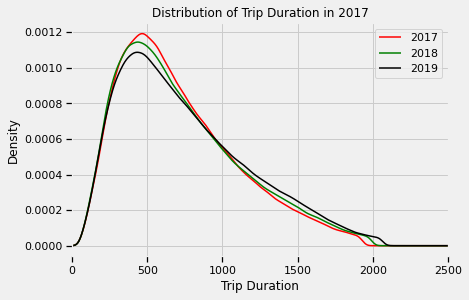

In [157]:
#Plot Distribution of Trip Duration in Minutes for each year
ridership_2017_clean['Trip Duration'].plot(kind='kde', color='r', label='2017')
ridership_2018_clean['Trip Duration'].plot(kind='kde', color='g', label='2018')
ridership_2019_clean['Trip Duration'].plot(kind='kde', color='black', label='2019')
#ridership_2020_clean['Trip Duration'].plot(kind='kde', color='blue', label='2020')
#ridership_2021_clean['Trip Duration'].plot(kind='kde', color='grey', label='2021')
#ridership_2022_clean['Trip Duration'].plot(kind='kde', color='y', label='2022')

plt.xlabel('Trip Duration')
plt.legend()
plt.xlim(0,2500)
plt.title('Distribution of Trip Duration in 2017')
plt.show()

In [253]:
#Import Toronto neighbourhoods file
neighbourhoods = gpd.read_file('toronto_neighbourhoods.shp')
neighbourhoods=neighbourhoods[['FIELD_8','geometry']]                           #drop all columns except FIELD_8 and geometry
neighbourhoods.rename(columns={'FIELD_8': 'name'}, inplace=True)                #renmae column'FIELD_8' with 'name'

import re                                                                       #import Regular expression operations to check for the brackets in names 
for row in range (len(neighbourhoods['name'])):                                 #iterate over the names of neighborhoods using  number of rows of names
    neighbourhoods['name'][row]=re.sub(r'\(\d+\)', '', str(neighbourhoods['name'][row]))  #remove id from each name in the column

#Import bike lanes file
bike_lanes = gpd.read_file('bikeway_network.shp')
bike_lanes = bike_lanes[['LF_NAME', 'SEG_TYPE', 'length', 'geometry']]   #get only the important columns
bike_lanes = bike_lanes.rename(columns={'LF_NAME': 'name', 'SEG_TYPE': 'route_type'})  #rename the columns
bike_lanes = bike_lanes[bike_lanes['route_type'] == 'bike lane']   #filter out all routes except for bike lanes

#Import subway station dataframe
subway_stations = gpd.read_file("subway_stations.shp")

In [276]:
#create a GeoDataFrame from bikeshare_stations dataframe and store in a new dataframe
bikeshare_stations_gdf = gpd.GeoDataFrame(bikeshare_stations,geometry=gpd.points_from_xy(bikeshare_stations.lon, bikeshare_stations.lat))
bikeshare_stations_gdf.crs = {'init': 'epsg:4326'}

Station Id      655
Station Name    655
lat             653
lon             654
capacity         39
geometry        655
dtype: int64

In [277]:
#Transform neighbourhoods, bikeshare_stations_gdf, subway_stations, and bike_lanes to EPSG:26917 (2D projection)
neighbourhoods = neighbourhoods.to_crs(epsg=26917)
bikeshare_stations_gdf = bikeshare_stations_gdf.to_crs(epsg=26917)
subway_stations = subway_stations.to_crs(epsg=26917)
bike_lanes = bike_lanes.to_crs(epsg=26917)

In [279]:
#Creat a new dataframe that merges the bikeshare stations with neighbourhoods
merged=gpd.sjoin(neighbourhoods, bikeshare_stations_gdf)
merged=merged.sort_values('Station Id')

655

In [305]:
#Creat a dictionary that maps each station to its neighbourhood
neighbourhood_map=dict(zip(merged['Station Id'],merged.name))  

In [299]:
def insert_neighourhood(df):
    """This function is get the start and end neighbourhood for each trip.
    """
    
    df['Start Station Id']=df['Start Station Id'].astype(int)
    df['End Station Id']=df['End Station Id'].astype(int)
    df['Start neighbourhood']=df['Start Station Id'].map(neighbourhood_map)
    df['End neighbourhood']=df['End Station Id'].map(neighbourhood_map)
    
    
    return df

In [311]:
with_neighbourhood_2017=insert_neighourhood(ridership_2017_clean) #apply this to the df_merged
with_neighbourhood_2018=insert_neighourhood(ridership_2018_clean)
with_neighbourhood_2019=insert_neighourhood(ridership_2019_clean)
with_neighbourhood_2022=insert_neighourhood(ridership_2022_clean)

In [315]:
count_of_trips_2017=with_neighbourhood_2017.groupby(by='Start neighbourhood')['Trip Id'].count().sort_values(ascending=False)
count_of_trips_2018=with_neighbourhood_2018.groupby(by='Start neighbourhood')['Trip Id'].count().sort_values(ascending=False)
count_of_trips_2019=with_neighbourhood_2019.groupby(by='Start neighbourhood')['Trip Id'].count().sort_values(ascending=False)
count_of_trips_2022=with_neighbourhood_2022.groupby(by='Start neighbourhood')['Trip Id'].count().sort_values(ascending=False)

Start neighbourhood
Bay Street Corridor                   262070
Waterfront Communities-The Island     244680
Church-Yonge Corridor                 114664
Kensington-Chinatown                  107377
Niagara                                79605
Name: Trip Id, dtype: int64

In [ ]:
mergeddf['Start Time'] = pd.to_datetime(mergeddf['Start Time'])
mergeddf['month'] = mergeddf['Start Time'].dt.month
mergeddf['day'] = mergeddf['Start Time'].dt.day
mergeddf['year'] = mergeddf['Start Time'].dt.year
mergeddf['hour'] = mergeddf['Start Time'].dt.hour
mergeddf['minute'] = mergeddf['Start Time'].dt.minute
mergeddf = mergeddf.sort_values(by=['Start Time'], ascending = True)

In [321]:

figure, ((ax1,ax2,ax3,ax4,ax5)) = plt.subplots(nrows=5, ncols =1)
figure.set_size_inches(15,20)

sns.countplot(data=mergeddf, x = 'year', ax = ax1)
sns.countplot(data=mergeddf, x = 'month', ax = ax2)
sns.countplot(data=mergeddf, x = 'day', ax = ax3)
sns.countplot(data=mergeddf, x = 'hour', ax = ax4)
sns.countplot(data=mergeddf, x = 'year', hue = 'User Type', ax=ax5)

NameError: name 'mastermergeddfdf' is not defined

## ML Model

## Conclusions